In [120]:
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
rng = np.random.default_rng()

from utils import *
from trajectories import *

T = 250 # how long to simulate the trajectory
num_traj_train = 100; num_traj_test = 20; num_traj = num_traj_train + num_traj_test

In [121]:
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = circular_traj_params()
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

<Figure size 432x288 with 0 Axes>

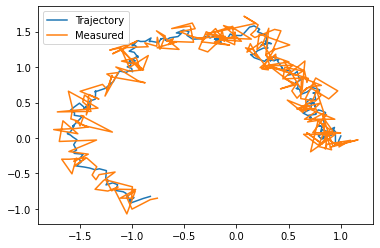

In [122]:
# plot a sample trajectory and noisy measurements
i = 0
plot_poses2d({'Trajectory': traj[i], 'Measured': meas[i]})

In [123]:
myTraj = traj[i]
myMeas = meas[i]
myUseq = u_seq[i]

## Minimum energy noise Optimization Using CVX 


The optimal value is 2.769485518079767


<Figure size 432x288 with 0 Axes>

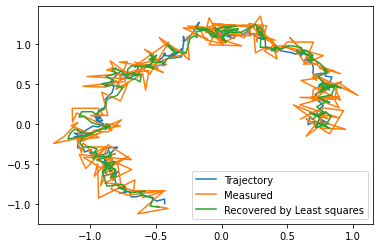

Average Error: 0.0059386407539944305


In [92]:
import cvxpy as cp

xs = cp.Variable((T, state_dim))

def obj_func(xs, ys, us, x0, A, B, C):
    '''Objective function for min-energy noise using cvxpy'''
    obj = 0
    for i in range(1, T):
        obj += cp.sum_squares(ys[i-1, :] - C @ xs[i-1, :].T)
        obj += cp.sum_squares(xs[i, :].T - A @ xs[i-1, :].T - B @ us[i, :].T)
        
    # Special handling for the first state
    obj += cp.sum_squares(xs[0, :] - A @ x0 - B @ us[0])
    # Observation error for the final state
    obj += cp.sum_squares(ys[T-1, :] - C @ xs[T-1, :].T)
    
    return obj

cost = obj_func(xs, myMeas, myUseq, x0, A, B, C)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

print("\nThe optimal value is", prob.value)
traj_recovered = xs.value

plt.figure()
fig, ax = plt.subplots()
linetraj = ax.plot(traj[i, CUT:, 0], traj[i, CUT:, 1], label='Trajectory')
linemeas = ax.plot(meas[i, CUT:, 0], meas[i, CUT:, 1], label='Measured')
linerecv = ax.plot(traj_recovered[CUT:, 0], traj_recovered[CUT:, 1], label='Recovered by Least squares')
plt.legend()
plt.show()

print('Average Error:', np.linalg.norm(traj_recovered[CUT:, :] - traj[i, CUT:, :])**2 / (T - CUT))

Converged in 18 iterations


<Figure size 432x288 with 0 Axes>

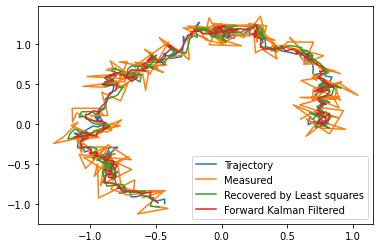

Average Error for Forward Kalman Filter: 0.0054907995268120855


In [95]:
from kalman_filter import *

kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
fltr = kinematics_forward.simulate(meas[i], u_seq[i])
    
plt.figure()
fig, ax = plt.subplots()
linetraj = ax.plot(traj[i, CUT:, 0], traj[i, CUT:, 1], label='Trajectory')
linemeas = ax.plot(meas[i, CUT:, 0], meas[i, CUT:, 1], label='Measured')
linerecv = ax.plot(traj_recovered[CUT:, 0], traj_recovered[CUT:, 1], label='Recovered by Least squares')
linefltr = ax.plot(fltr[CUT:, 0], fltr[CUT:, 1], label='Forward Kalman Filtered')
plt.legend()
plt.show()
    
print("Average Error for Least Squares", np.linalg.norm(fltr)
print("Average Error for Forward Kalman Filter:", np.linalg.norm(fltr - myTraj)**2 / (T - CUT))

Measurements
 [[ 9.94161987e-01  5.31996346e-02]
 [ 1.05616739e+00  1.88932166e-01]
 [ 9.42283925e-01  3.84326909e-02]
 [ 8.70123745e-01 -9.51913152e-02]
 [ 7.64882939e-01  5.22634229e-02]
 [ 6.00285892e-01  6.61987491e-02]
 [ 7.12688776e-01  1.64195365e-01]
 [ 7.92724549e-01  1.54529071e-01]
 [ 6.41323542e-01 -1.49602937e-01]
 [ 7.81695259e-01  1.91491545e-02]
 [ 9.43178465e-01 -6.29985287e-02]
 [ 7.53676718e-01 -4.66697035e-02]
 [ 6.43043895e-01  6.73682863e-02]
 [ 8.20120725e-01 -1.19636166e-01]
 [ 9.26885209e-01  1.71490892e-01]
 [ 7.66272137e-01  2.07758040e-01]
 [ 7.50582376e-01 -3.12459838e-03]
 [ 5.45765974e-01  2.43823482e-01]
 [ 8.08439590e-01  6.99339331e-02]
 [ 7.07605143e-01  1.32789091e-01]
 [ 8.91169969e-01  8.07783290e-02]
 [ 5.93753059e-01  2.43699223e-01]
 [ 8.41843488e-01  3.57584655e-01]
 [ 8.92948114e-01  2.05169802e-01]
 [ 6.83096465e-01  3.43733532e-01]
 [ 8.65578552e-01  3.13570037e-01]
 [ 5.95029030e-01  3.36109838e-01]
 [ 8.91432849e-01  3.41603813e-01]
 [ 8.6

<Figure size 432x288 with 0 Axes>

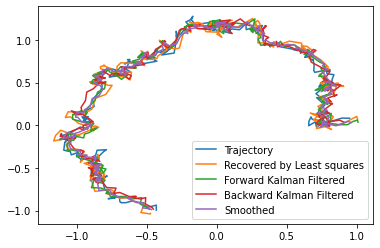

Average Error for Least Squares 0.005968055700592968
Average Error for Forward Kalman Filter: 0.005380983536275844
Average Error for Backward Kalman Fitler 0.005651888780466533
Average Error for Smoothed Kalman Filter 0.003919183589490021


In [107]:
kinematics_backward = KFilter(np.linalg.inv(A), -np.linalg.inv(A) @ B, C, Q, R, state=myTraj[-1])
revMeas = myMeas[::-1, :]
print("Measurements\n", myMeas)
print("Reversed Measurements\n", revMeas)
fltr_back = np.flip(kinematics_backward.simulate(revMeas), axis=0)
smooth_states = (fltr + fltr_back) / 2

plt.figure()
fig, ax = plt.subplots()
linetraj = ax.plot(myTraj[:, 0], myTraj[:, 1], label='Trajectory')
# linemeas = ax.plot(myMeas[:, 0], myMeas[:, 1], label='Measured')
linerecv = ax.plot(traj_recovered[:, 0], traj_recovered[:, 1], label='Recovered by Least squares')
linefltr = ax.plot(fltr[:, 0], fltr[:, 1], label='Forward Kalman Filtered')
linefltrback = ax.plot(fltr_back[:, 0], fltr[:, 1], label='Backward Kalman Filtered')
linesmooth = ax.plot(smooth_states[:, 0], smooth_states[:, 1], label='Smoothed')
plt.legend()
plt.show()
    
print("Average Error for Least Squares", np.linalg.norm(traj_recovered - myTraj)**2 / T) 
print("Average Error for Forward Kalman Filter:", np.linalg.norm(fltr - myTraj)**2 / T)
print("Average Error for Backward Kalman Fitler", np.linalg.norm(fltr_back - myTraj)**2 / T)
print("Average Error for Smoothed Kalman Filter", np.linalg.norm(smooth_states - myTraj)**2 / T)

## Solving the learned Kalman Filter using CVXPY

This doesn't actually work since the repeated multiplication by the dynamics jacobian results in a problem that is highly non-convex. The only way to learn the KF is by pytorching through it.

In [112]:
Aprime = cp.Variable((state_dim, state_dim))
Bprime = cp.Variable((state_dim, input_dim))
Gprime = cp.Variable((state_dim, obs_dim))
Cprime = cp.Variable((obs_dim, state_dim))

def obj_func_learnkf(ys, us, x0, Aprime, Bprime, Gprime, Cprime):
    '''Objective function for learning Kalman Filter Parameters using cvxpy'''
    obj = 0
    curr_state = x0
    for t in range(T-1):
        next_estimate = Aprime @ curr_state + Bprime @ us[t] + Gprime @ ys[t]
        next_obs_estimate = Cprime @ next_estimate
        obj += cp.sum_squares(next_obs_estimate - ys[t+1])
        curr_state = next_estimate
    return obj

# Solve the problem with CVXPY
cost = obj_func_learnkf(myMeas, myUseq, x0, Aprime, Bprime, Gprime, Cprime)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

# Recover the optimal values
print("\nThe optimal value is", prob.value)
A_recv = Aprime.value
B_recv = Bprime.value
G_recv = Gprime.value
C_recv = Cprime.value

# Recover the positions using the learned KF

states = np.zeros(shape=(T, state_size))
curr_state = x0
for t in range(T):
    next_state = A_recv @ curr_state + B_recv @ us[t] + G_recv @ ys[t]
    states[t] = next_state
    curr_state = next_state

print("Recovered States", states)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
var189233 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])
var189230 @ (var189230 @ [1. 0.] + var189231 @ [0.02514858] + var189232 @ [0.99416199 0.05319963])

## Quantify the error if we just predict the previous token (identity map) - ie. no learning involved

In [113]:
myTraj = traj[i]
myMeas = meas[i]
myUseq = u_seq[i]

In [116]:
error = 0
for t in range(1,T):
    error += np.linalg.norm(myMeas[t] - myMeas[t-1])**2
print("Error is", error / T)

Error is 0.03889612729345197
